# Análisis de archivos XSLX con Python
Fechao: 16/08/202

Este proyecto analiza datos de acciones almacenados en archivos Excel, utilizando técnicas avanzadas de regresión para obtener perspectivas predictivas.
3

### Importación de Bibliotecas
Primero, vamos a importar las bibliotecas y paquetes que necesitamos para el análisis de datos y la construcción del modelo. Además, definiremos algunas constantes que se usarán más adelante Cambie el valor de EXCEL_FILE_NAME con el archivo de trabajo.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn import svm, model_selection

# Constantes
EXCEL_FILE_NAME = 'Hoja_1.xlsx'
COLUMN_NAMES = {
    "price": "PX_LAST",
    "features": ['PX_MID', 'PX_LOW', 'PX_HIGH', 'PX_OPEN', 'RSI_14D', 'RSI_30D', 'RSI_9D', 'RSI_3D'],
    "detail": 'DETALLE',
}
INDEX_COLUMN = 'FECHA'
DEFAULT_DTYPE = 'float64'

class SheetResult:
    def __init__(self, sheet_name, final_value):
        self.sheet_name = sheet_name
        self.final_value = final_value
        
    def __str__(self):
        return f"Hoja: {self.sheet_name}, Valor final: {self.final_value}"

print("Librerías y paquetes cargados.")

Librerías y paquetes cargados.


### Carga de Datos

La función `load_data  carga los datos desde un archivo Excel. Esta función también maneja posibles errores al intentar abrir el archivo


In [2]:
def load_data(file_name=EXCEL_FILE_NAME):
    try:
        data = pd.read_excel(file_name, sheet_name=None, engine='openpyxl', index_col=INDEX_COLUMN)
        
        if not data:
            message = f"🚨 [ERROR]: El archivo '{file_name}' está vacío o no contiene datos validos."
            return None, message
        
        return data, "Data cargada correctamente"
        
    except FileNotFoundError:
        message = f"🚨 [ERROR]: El archivo '{file_name}' no fue encontrado. Por favor comprueba la ubicación (path) y el nombre del archivo."
        return None, message
    except Exception as e:
        message = f"🚨 [ERROR]: No se puede abrir el archivo '{file_name}'. Error: {str(e)}"
        return None, message

all_data, message = load_data()

print(message)
if all_data:
    first_sheet_name = list(all_data.keys())[0]
    print(f"\nSample de la data de la primera hoja: {first_sheet_name}")
    display(all_data[first_sheet_name].head())

Data cargada correctamente

Sample de la data de la primera hoja: LYB UN Equity


,PX_LAST,PX_MID,PX_LOW,PX_HIGH,PX_OPEN,LAST_PRICE,PX_VOLUME,RSI_14D,RSI_30D,RSI_9D,RSI_3D,DETALLE,VARIACIￓN
FECHA,,,,,,,,,,,,,
2020-02-11,83.97,83.965,82.68,84.750,82.80,83.97,459435,39.7113,36.3713,53.6842,58.7332,1,0.024899
2020-02-12,85.61,85.595,84.59,86.580,85.88,85.61,546885,43.8843,39.1364,58.5764,75.8427,1,0.019531
2020-02-13,83.49,83.515,83.38,85.345,84.80,83.49,429671,40.0273,36.9870,50.7766,42.0430,0,-0.024763
2020-02-14,82.60,82.605,81.88,83.650,83.65,82.60,690749,38.4976,36.1253,47.7723,32.8297,0,-0.010660
2020-02-18,81.32,81.325,80.41,82.620,82.04,81.32,409287,36.3462,34.9151,43.5986,22.2915,0,-0.015496


### Preprocesamiento de Datos

Antes de entrenar nuestro modelo, es necesario preprocesar los datos. Esta etapa incluye convertir columnas a formato numérico y normalizarlas.

In [3]:
def ensure_float64(df):
    if not all(df.dtypes == 'float64'):
        raise ValueError("Todas las columnas deben ser de tipo float64")

def preprocess_data(df):
    columns_to_check = [COLUMN_NAMES["price"], COLUMN_NAMES["detail"]] + COLUMN_NAMES["features"]
    for column in columns_to_check:
        is_non_numeric = pd.to_numeric(df[column], errors='coerce').isna()
        
        if is_non_numeric.sum() > 0:
            print(f"Valores no numéricos encontrados en la columna '{column}'. Los valores no numéricos serán convertidos a NaN.")
            
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column] = df[column].astype('float64')

    df.fillna(method='ffill', inplace=True)
    df['PX_VOLUME'] = df['PX_VOLUME'].astype('float64')

    df = df[pd.to_numeric(df[COLUMN_NAMES["detail"]], errors='coerce').notnull()]
    df.loc[:, COLUMN_NAMES["detail"]] = df[COLUMN_NAMES["detail"]].astype('float')
    
    ensure_float64(df)

    columns_to_normalize = [COLUMN_NAMES["price"]] + COLUMN_NAMES["features"]
    for column in columns_to_normalize:
        df.loc[:, column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    return df

for sheet_name, df in all_data.items():
    all_data[sheet_name] = preprocess_data(df)

print(f"Muestra de la data preprocesada de la primera hoja: {first_sheet_name}\n")
display(all_data[first_sheet_name].head())

Valores no numéricos encontrados en la columna 'DETALLE'. Los valores no numéricos serán convertidos a NaN.
Muestra de la data preprocesada de la primera hoja: LYB UN Equity



,PX_LAST,PX_MID,PX_LOW,PX_HIGH,PX_OPEN,LAST_PRICE,PX_VOLUME,RSI_14D,RSI_30D,RSI_9D,RSI_3D,DETALLE,VARIACIￓN
FECHA,,,,,,,,,,,,,
2020-02-11,0.591490,0.591268,0.599217,0.561482,0.572586,83.97,459435.0,0.412499,0.370740,0.571862,0.582878,1.0,0.024899
2020-02-12,0.611258,0.610927,0.622598,0.585614,0.610382,85.61,546885.0,0.478288,0.428748,0.636263,0.760473,1.0,0.019531
2020-02-13,0.585704,0.585841,0.607786,0.569328,0.597128,83.49,429671.0,0.417481,0.383657,0.533587,0.409636,0.0,-0.024763
2020-02-14,0.574976,0.574866,0.589423,0.546977,0.583016,82.60,690749.0,0.393364,0.365580,0.494039,0.314002,0.0,-0.010660
2020-02-18,0.559547,0.559428,0.571429,0.533395,0.563259,81.32,409287.0,0.359446,0.340191,0.439097,0.204617,0.0,-0.015496


### Entrenamiento del Modelo

Una vez que los datos están preprocesados, podemos entrenar nuestro modelo de regresión usandoel MLP Regressor.


In [4]:
def train_model(df):
    feature_cols = COLUMN_NAMES["features"]
    
    # Dividir datos para entrenamiento y prueba
    train_size = int(0.8 * len(df))
    datos_entrenamiento = df.iloc[:train_size]
    datos_prueba = df.iloc[train_size:]
    
    X_train = datos_entrenamiento[feature_cols].values
    Y_train = datos_entrenamiento[COLUMN_NAMES["detail"]].values.astype('float')
    X_test = datos_prueba[feature_cols].values
    Y_test = datos_prueba[COLUMN_NAMES["detail"]].values.astype('float')
    
    # Entrenar el MLP Regressor
    modelo_red_neuronal = MLPRegressor(activation='logistic', hidden_layer_sizes=(200), max_iter=1000, solver='adam')
    modelo_red_neuronal.fit(X_train, Y_train)
    
    return modelo_red_neuronal, X_test, Y_test

trained_models = {}
for sheet_name, df in all_data.items():
    model, X_test, Y_test = train_model(df)
    trained_models[sheet_name] = (model, X_test, Y_test)

print("Modelos entrenados para todas las hojas.")

print(f"\nEjemplo del X_test de la primera hoja: {first_sheet_name}")
pd.DataFrame(trained_models[first_sheet_name][1]).head()

Modelos entrenados para todas las hojas.

Ejemplo del X_test de la primera hoja: LYB UN Equity


,0,1,2,3,4,5,6,7
0,0.588374,0.579998,0.563592,0.558228,0.725043,0.707392,0.709931,0.838141
1,0.587650,0.587098,0.551856,0.578353,0.723270,0.706390,0.707568,0.831627
2,0.598746,0.601665,0.565966,0.588907,0.752761,0.728291,0.740534,0.869623
3,0.544956,0.566777,0.546977,0.582157,0.569773,0.620264,0.504977,0.332762
4,0.590906,0.591504,0.552120,0.575040,0.688543,0.706318,0.645193,0.629159


### Evaluación del Modelo

Con los modelos entrenados, podemos evaluar su rendimiento y determinar elthresholdl óptimo para la clasificación


In [5]:
def evaluate_model(model, X_test, Y_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({
        'fpr': pd.Series(fpr, index=i), 
        'tpr': pd.Series(tpr, index=i), 
        '1-fpr': pd.Series(1-fpr, index=i), 
        'tf': pd.Series(tpr - (1-fpr), index=i), 
        'thresholds': pd.Series(thresholds, index=i)
    })
    optimal_threshold = roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]

    conteo_positivos_reales  = np.sum(Y_test)
    df_predicciones = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
    df_predicciones['threshold_comparison'] = (df_predicciones['Predicted'] > optimal_threshold).astype(int)
    conteo_positivos_predichos = df_predicciones['threshold_comparison'].sum()

    final_value = conteo_positivos_reales - conteo_positivos_predichos
    return final_value, df_predicciones, optimal_threshold, conteo_positivos_reales, conteo_positivos_predichos

results = []
sample_df_temp = None
for sheet_name, (model, X_test, Y_test) in trained_models.items():
    final_value, df_temp, optimal_threshold, conteo_positivos_reales, conteo_positivos_predichos = evaluate_model(model, X_test, Y_test)
    results.append(SheetResult(sheet_name, final_value))
    if sample_df_temp is None:
        sample_df_temp = df_temp
        sample_threshold = optimal_threshold

print(f"Solo mostraremos una hoja de ejemplo para su análisis.")
print(f"El threshold de esta hoja es: {sample_threshold}\n")
print(f"conteo_positivos_reales: {conteo_positivos_reales}")
print(f"conteo_positivos_predichos: {conteo_positivos_predichos}")
sample_df_temp

Solo mostraremos una hoja de ejemplo para su análisis.
El threshold de esta hoja es: 0.5126928302167679

conteo_positivos_reales: 86.0
conteo_positivos_predichos: 85


,Actual,Predicted,threshold_comparison
0,1.0,0.866832,1
1,0.0,0.855485,1
2,1.0,0.889776,1
3,0.0,0.282220,0
4,1.0,0.614096,1
...,...,...,...
168,1.0,0.721046,1
169,1.0,0.848707,1
170,0.0,0.686455,1
171,0.0,0.260754,0


Nota: en la celda anterior se pueden ver muchos valores con 0. Estos valores tienden a estar en una zona particular de la data. Para ello, vamos a guardar toda la data de esta hoja de ejemplo en un archivo txt.

In [6]:
sample_df_temp.to_csv('sample_df_temp.txt', sep='\t', index=False)
print(f"¡El archivo se ha guardado exitosamente!")

¡El archivo se ha guardado exitosamente!


#### Evaluación manual

Quizá sea relevante saber en qué parte de nuestra lista se ha logrado obtener datos positivos (es decir, de 1). Estos se pueden ver en la gráfica a continuación.

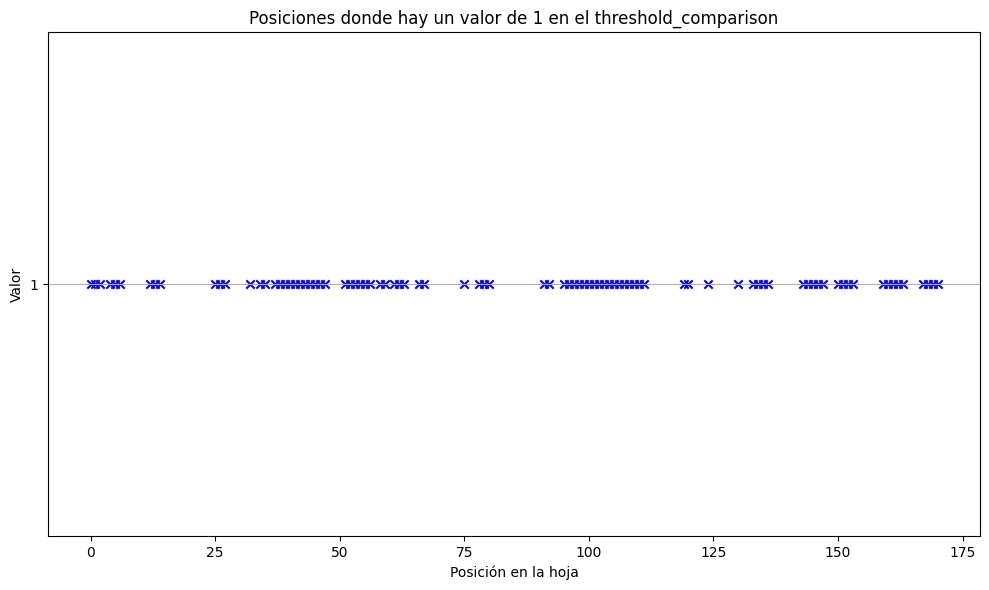

In [7]:
subset_df = sample_df_temp[sample_df_temp['threshold_comparison'] == 1]

plt.figure(figsize=(10,6))
plt.scatter(subset_df.index, subset_df['threshold_comparison'], c='blue', marker='x')
plt.title('Posiciones donde hay un valor de 1 en el threshold_comparison')
plt.xlabel('Posición en la hoja')
plt.ylabel('Valor')
plt.yticks([1])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Resultados

Creemos undfe para visualizar los resultados decada hoja.


In [8]:
data = [{'sheet_name': result.sheet_name, 'final_value': result.final_value} for result in results]
df_results = pd.DataFrame(data)
df_results.head()

,sheet_name,final_value
0,LYB UN Equity,3.0
1,AVGO UW Equity,3.0
2,BA UN Equity,8.0
3,CAT UN Equity,1.0
4,JPM UN Equity,5.0


### Ordenamiento de Resultados

Ordenaremos los resultados en función del valor final. De mayor a menor. Para poder obtener los primeros 10 o últimos 10, es decir, los mejores y peores.

In [9]:
sorted_results = sorted(results, key=lambda x: x.final_value, reverse=True)

### Las 10 mejores hojas


In [10]:
print("Las 10 mejores 📈:")
best_10 = [(r.sheet_name, r.final_value) for r in sorted_results[:10]]
pd.DataFrame(best_10, columns=['Sheet Name', 'Value'])

Las 10 mejores 📈:


,Sheet Name,Value
0,BA UN Equity,8.0
1,JPM UN Equity,5.0
2,LYB UN Equity,3.0
3,AVGO UW Equity,3.0
4,Sheet14,2.0
5,CAT UN Equity,1.0
6,Sheet,1.0
7,Sheet2,1.0
8,Sheet3,1.0
9,Sheet4,1.0


### Las 10 peores hojas

In [11]:
print("\nLas 10 peores 📉:")
worst_10 = [(r.sheet_name, r.final_value) for r in sorted_results[-10:]]
pd.DataFrame(worst_10, columns=['Sheet Name', 'Value'])


Las 10 peores 📉:


,Sheet Name,Value
0,Sheet13,1.0
1,Sheet15,1.0
2,Sheet16,1.0
3,Sheet17,1.0
4,Sheet18,1.0
5,Sheet19,1.0
6,DIS UN Equity,1.0
7,Sheet20,1.0
8,Sheet21,1.0
9,KO UN Equity,0.0
